In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import xarray as xr
import os
import sys
from scipy.optimize import curve_fit
import pickle

In [7]:
# Open a GOES-16 NetCDF file
path = r'C:\Users\steve\goes16\2018\12\12\ABI-L1b-RadC\18\C02\OR_ABI-L1b-RadC-M3C02_G16_s20183461802178_e20183461804551_c20183461804590.nc'
g16_b02 = xr.open_dataset(path)

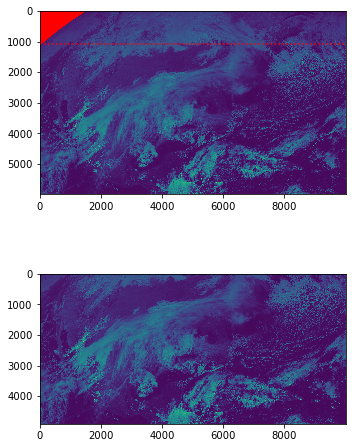

In [102]:
# Plot the image
f, ax = plt.subplots(2,1,figsize=(5,7))
ax[0].imshow(g16_b02.Rad)

# Find the nan values
nan_y, nan_x = np.asarray(np.isnan(g16_b02.Rad)).nonzero()
ax[0].plot(nan_x, nan_y,'r') # nan values
ax[0].axhline(y=np.max(nan_y), color='r', linestyle=':') # trim above this line for now

# Find the y coordinate where the nan values start, so that we can
# trim away everything above that and don't have to deal with nans later

# Plot the new image
ax[1].imshow(g16_b02.Rad[np.max(nan_y):,:])

f.tight_layout()

In [103]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lat,lon)



In [114]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(g16_b02.x.values, g16_b02.y[np.max(nan_y):].values) 
# note that I'm skipping rows with nan here

# Values needed for geometry calculations
req = g16_b02.goes_imager_projection.semi_major_axis # semi major axis
rpol = g16_b02.goes_imager_projection.semi_minor_axis
H = g16_b02.goes_imager_projection.perspective_point_height + g16_b02.goes_imager_projection.semi_major_axis
lon_0 = g16_b02.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [120]:
# Pixel coordinates of x and y:
xs = np.linspace(0,g16_b02.x.shape[0],g16_b02.x.shape[0],dtype='int16')
ys = np.linspace(0,g16_b02.y[np.max(nan_y):].shape[0],g16_b02.y[np.max(nan_y):].shape[0],dtype='int16')
# note that I'm skipping rows with nan here
x, y = np.meshgrid(xs,ys)

In [121]:
## Show that we can find the pixels corresponding to a known lat and lon point
## such as Grand Mesa, CO: 39.034846, -108.212194
#
#y_lat, x_lat = np.where((lat>39.0348) & (lat <39.0349))
#y_lon, x_lon = np.where((lon>-108.2122) & (lon<-108.2121))
#
#
#plt.imshow(g16_b02.Rad)
##plt.colorbar()
#plt.plot(x_lat,y_lat,'.w')
#plt.plot(x_lon,y_lon,'.w')
#

In [160]:
# Normalize everything to [-1,1]
# We have to use np.nanmin and np.nanmax on the lat and lon arrays, 
# because GOES images contain nan values where its pointed beyond the limb of the Earth

# Normalize latitude to [-1,1]:
LAT_OFF = np.nanmin(lat)
LAT_SCALE = np.nanmax(lat) - np.nanmin(lat)
lat_norm = 2 * ((lat - LAT_OFF) / LAT_SCALE) - 1
lat_norm = lat_norm.astype(np.float64)

# Normalize longitude to [-1,1]:
LON_OFF = np.nanmin(lon)
LON_SCALE = np.nanmax(lon) - np.nanmin(lon)
lon_norm = 2 * ((lon - LON_OFF) / LON_SCALE) - 1
lon_norm = lon_norm.astype(np.float64)

# Normalize row (y) to [-1,1]:
Y_OFF = y.min()
Y_SCALE = y.max() - y.min()
y_norm = 2 * ((y - Y_OFF) / Y_SCALE) - 1

# Normalize column (x) to [-1,1]:
X_OFF = x.min()
X_SCALE = x.max() - x.min()
x_norm = 2 * ((x - X_OFF) / X_SCALE) - 1

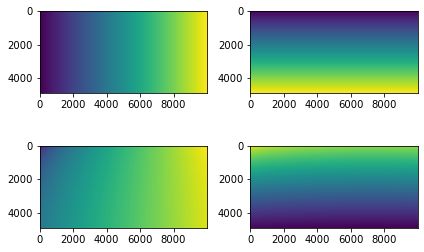

In [162]:
# Visualize the arrays of x, y (scan angle radians), and longitude, latitude (degrees)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_norm)
ax[0,1].imshow(y_norm)
ax[1,0].imshow(lon_norm)
ax[1,1].imshow(lat_norm)
fig.tight_layout()

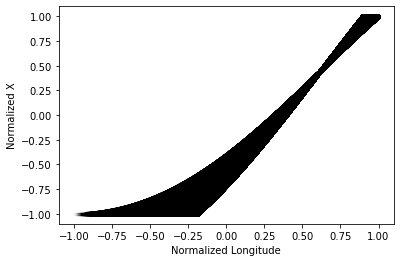

In [124]:
# Visualize longitude (degrees) vs x (pixel coord)
plt.plot(lon_norm,x_norm,'.k',alpha=0.01);
plt.xlabel('Normalized Longitude');
plt.ylabel('Normalized X');

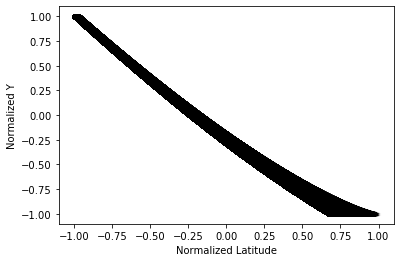

In [125]:
# Visualize latitude (degrees) vs y (pixel coord)
plt.plot(lat_norm,y_norm,'.k',alpha=0.01);
plt.xlabel('Normalized Latitude');
plt.ylabel('Normalized Y');

Pickle these arrays to a file

In [163]:
normalized_curves = { 'x_norm': x_norm, 'y_norm': y_norm, 'lon_norm': lon_norm, 'lat_norm': lat_norm }
file = open('normalized_curves_noNans.pickle', 'wb') 
pickle.dump(normalized_curves, file)

***
***
Fit RPCs to these two surfaces:

https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting

http://geotiff.maptools.org/STDI-0002_v2.1.pdf (Section 8.4.2)

In [164]:
def map2rpc(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,
            b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19):
    
    x, y, z = in_xyz
    
    num_l = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    # should b0 = 1? https://doi.org/10.5194/isprs-archives-XLII-3-2511-20
    b0 = 1
    den_l = b0 + b1*x + b2*y + b3*z + b4*x*y + b5*x*z + b6*y*z + b7*x**2 + b8*y**2 + b9*z**2 + b10*x*y*z + b11*x**3 + b12*x*y**2 + \
    b13**x*z**2 + b14*y*x**2 + b15*y**3 + b16*y*z**2 + b17*x**2*z + b18*y**2*z + b19*z**3
    
    return num_l / den_l # previously num_l/den_l ... https://doi.org/10.5194/isprs-archives-XLII-3-2511-20

In [165]:
# set elevations to 0, on the surface of the ellipsoid??
z_norm = np.zeros_like(lat_norm)

In [166]:
# Pick out n random indices to use for fitting
n = 10000
idx1 = np.random.randint(0, z_norm.shape[0], n)
idx2 = np.random.randint(0, z_norm.shape[1], n)

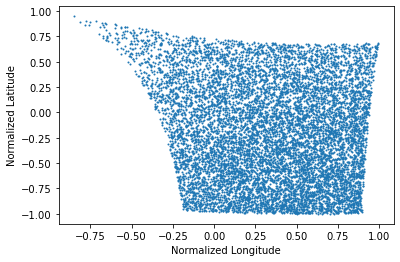

In [167]:
# random lat/lon points:
plt.scatter(lon_norm[idx1,idx2].flatten(),lat_norm[idx1,idx2].flatten(),s=1)
plt.xlabel('Normalized Longitude');
plt.ylabel('Normalized Latitude');

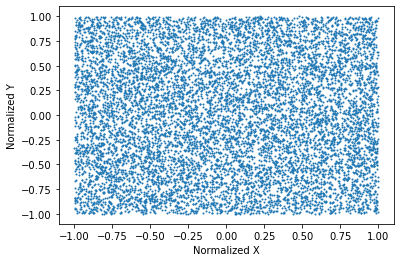

In [168]:
# corresponding random x/y points
plt.scatter(x_norm[idx1,idx2].flatten(),y_norm[idx1,idx2].flatten(),s=1)
plt.xlabel('Normalized X');
plt.ylabel('Normalized Y');

In [171]:
# can try map2rpc or mat2rpc_test, which solves for only 20 of the 40 coefficients
a = curve_fit(map2rpc, 
              (lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()), 
              x_norm[idx1,idx2].flatten(),
              method='lm',
              maxfev=1000)

a

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [145]:
b = curve_fit(map2rpc, 
              (lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()), 
              y_norm[idx1,idx2].flatten())

b

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]), array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]))

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


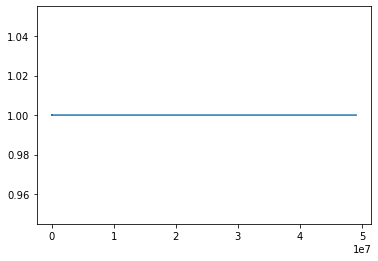

In [142]:
fit_x = map2rpc((x_norm.flatten(),y_norm.flatten(),z_norm.flatten()),*a[0])
plt.plot(fit_x)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


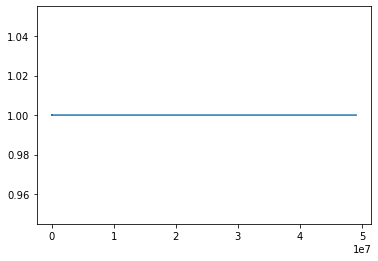

In [143]:
fit_y = map2rpc((x_norm.flatten(),y_norm.flatten(),z_norm.flatten()),*b[0])
plt.plot(fit_y)

***
***
Try RPC curve fitting with Orfeo Toolbox

In [3]:
#sys.path.append(r'C:\Program Files\OTB-6.6.1-Win64\bin')
sys.path.append(r'C:\Program Files\OTB-6.6.1-Win64\lib\python3')
import otbApplication

ImportError: DLL load failed: The specified module could not be found.

***
***
Test curve fitting with fake data

In [ ]:
def map2rpc_test(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19):
    
    x, y, z = in_xyz
    
    solution = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    return solution

In [ ]:
n = 10000
x = np.linspace(0,1, n)
y = np.linspace(0,1, n)
z = np.linspace(0,1, n)
a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19 = np.random.randint(0,5,20)
#b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19 = np.random.randint(0,5,20)
true_coeffs = np.array([a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19])
# true values of all these coefficients
true = map2rpc_test((x,y,z),a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19)
noisy = true  + ( np.random.random(n) - np.random.random(n) ) / 1

In [ ]:
plt.plot(noisy,label='noisy')
plt.plot(true,label='true')
plt.legend()

In [ ]:
popt, pcov = curve_fit(map2rpc_test, (x,y,z), noisy, bounds=(-5,5))
#print(popt, pcov)

In [ ]:
plt.plot(popt,true_coeffs,'.k')
plt.ylabel('true values')
plt.xlabel('curve_fit values')
plt.plot([-20,20],[-20,20],':b')

In [ ]:
popt

In [ ]:
true_coeffs

In [ ]:
fit = map2rpc_test((x,y,z),*popt)

In [ ]:
plt.plot(noisy,label="noisy")
plt.plot(true,label="true")
plt.plot(fit,label="fit")
plt.legend()

In [ ]:
#plt.plot(true - noisy,label="true - noisy")
plt.plot(true - fit,label="true - fit")
plt.legend()